# Approach 1: Using ResNet50 for feature extraction and MLP for classification

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:
train = "/kaggle/input/hackathon-new/Hacklytics/data/train"
test = "/kaggle/input/hackathon-new/Hacklytics/data/test"

In [4]:
mal_train = "/kaggle/input/hackathon-new/Hacklytics/data/train/malignant"
ben_train = "/kaggle/input/hackathon-new/Hacklytics/data/train/benign"

In [5]:
from IPython.core.pylabtools import figsize

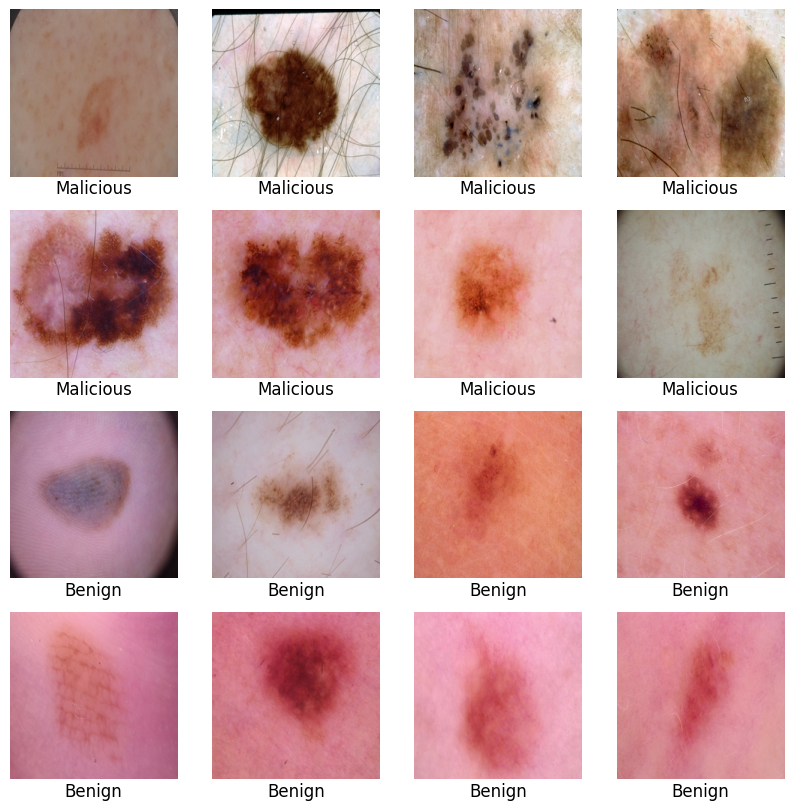

In [6]:
sample_mal = [os.path.join(mal_train,np.random.choice(os.listdir(mal_train),1)[0]) for _ in range(8)]
sample_ben = [os.path.join(ben_train,np.random.choice(os.listdir(ben_train),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

# Define labels for each class
mal_label = 'Malicious'
ben_label = 'Benign'

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(sample_mal[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
    ax[i].text(0.5, -0.1, mal_label, ha='center', transform=ax[i].transAxes, fontsize=12)
  else:
    pic = plt.imread(sample_ben[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
    ax[i].text(0.5, -0.1, ben_label, ha='center', transform=ax[i].transAxes, fontsize=12)
plt.show()

In [7]:
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2

In [8]:
#transformations (can explore v2 transformers as well)
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(degrees=30),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

In [9]:
#datasets
train_data = datasets.ImageFolder(train,transform=train_transforms)
test_data = datasets.ImageFolder(test,transform=test_transforms)

In [10]:
#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = False, batch_size=16)

In [11]:
# Training function
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss
  return train_step

In [12]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


In [14]:
#freeze all params
for params in model.parameters():
    params.requires_grad_ = False

In [15]:
#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer

classifier_head = nn.Sequential(
nn.Linear(nr_filters, 512),
nn.ReLU(inplace=True),
nn.Dropout(p=0.5),
nn.Linear(512, 1))
model.fc = classifier_head

model = model.to(device)

In [16]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [17]:
#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [18]:
%%capture
!pip install tqdm

In [19]:
from tqdm import tqdm

In [20]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 20
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [22]:
for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
        x_batch , y_batch = data
        x_batch = x_batch.to(device) #move to gpu
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu

        loss = train_step(x_batch, y_batch)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)
    
    # Update Learning Rate
#     scheduler.step()
    
    epoch_train_losses.append(epoch_loss.item())
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    
      #validation doesnt requires gradient
    with torch.no_grad():
        cum_loss = 0
        all_predictions = []
        all_targets = []
        for x_batch, y_batch in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device)
            
            #model to eval mode
            model.eval()
            
            yhat = model(x_batch)
            val_loss = loss_fn(yhat,y_batch)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())
            
            # Calculate predictions and ground truth labels
            predictions = (yhat > 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
            
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        precision = precision_score(all_targets, all_predictions)
        recall = recall_score(all_targets, all_predictions)
        f1 = f1_score(all_targets, all_predictions)
        cm = confusion_matrix(all_targets, all_predictions)
        
        
        epoch_test_losses.append(cum_loss.item())
        print('Epoch : {}, val loss : {:.4f}'.format(epoch + 1, cum_loss))
        print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'.format(accuracy, precision, recall, f1))
        print('Confusion Matrix:')
        print(cm)
        
        best_loss = min(epoch_test_losses)
    
        #save best model
        if cum_loss <= best_loss:
            best_model_wts = model.state_dict()

        #early stopping
        early_stopping_counter = 0
        if cum_loss > best_loss:
            early_stopping_counter +=1

        if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
            print("/nTerminating: early stopping")
            break #terminate training
        
        scheduler.step(cum_loss)

#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 169/169 [00:37<00:00,  4.49it/s]



Epoch : 1, train loss : 0.4272541105747223
Epoch : 1, val loss : 0.4079
Accuracy: 0.8242, Precision: 0.8538, Recall: 0.7400, F1 Score: 0.7929
Confusion Matrix:
[[322  38]
 [ 78 222]]


100%|██████████| 169/169 [00:25<00:00,  6.62it/s]



Epoch : 2, train loss : 0.36522895097732544
Epoch : 2, val loss : 0.1561
Accuracy: 0.8379, Precision: 0.8143, Recall: 0.8333, F1 Score: 0.8237
Confusion Matrix:
[[303  57]
 [ 50 250]]


100%|██████████| 169/169 [00:26<00:00,  6.46it/s]



Epoch : 3, train loss : 0.34310394525527954
Epoch : 3, val loss : 0.7196
Accuracy: 0.8394, Precision: 0.8674, Recall: 0.7633, F1 Score: 0.8121
Confusion Matrix:
[[325  35]
 [ 71 229]]


100%|██████████| 169/169 [00:26<00:00,  6.33it/s]



Epoch : 4, train loss : 0.32419371604919434
Epoch : 4, val loss : 1.0265
Accuracy: 0.8303, Precision: 0.8917, Recall: 0.7133, F1 Score: 0.7926
Confusion Matrix:
[[334  26]
 [ 86 214]]


100%|██████████| 169/169 [00:26<00:00,  6.41it/s]



Epoch : 5, train loss : 0.3166813850402832
Epoch : 5, val loss : 0.2715
Accuracy: 0.8364, Precision: 0.9034, Recall: 0.7167, F1 Score: 0.7993
Confusion Matrix:
[[337  23]
 [ 85 215]]


100%|██████████| 169/169 [00:26<00:00,  6.39it/s]



Epoch : 6, train loss : 0.3068218529224396
Epoch : 6, val loss : 0.9554
Accuracy: 0.8455, Precision: 0.8722, Recall: 0.7733, F1 Score: 0.8198
Confusion Matrix:
[[326  34]
 [ 68 232]]
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 7, train loss : 0.2778679132461548
Epoch : 7, val loss : 0.5127
Accuracy: 0.8470, Precision: 0.8996, Recall: 0.7467, F1 Score: 0.8160
Confusion Matrix:
[[335  25]
 [ 76 224]]


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 8, train loss : 0.2864893674850464
Epoch : 8, val loss : 0.2039
Accuracy: 0.8424, Precision: 0.9016, Recall: 0.7333, F1 Score: 0.8088
Confusion Matrix:
[[336  24]
 [ 80 220]]


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 9, train loss : 0.26233550906181335
Epoch : 9, val loss : 0.4068
Accuracy: 0.8455, Precision: 0.9091, Recall: 0.7333, F1 Score: 0.8118
Confusion Matrix:
[[338  22]
 [ 80 220]]


100%|██████████| 169/169 [00:26<00:00,  6.37it/s]



Epoch : 10, train loss : 0.2743908762931824
Epoch : 10, val loss : 0.2364
Accuracy: 0.8545, Precision: 0.9048, Recall: 0.7600, F1 Score: 0.8261
Confusion Matrix:
[[336  24]
 [ 72 228]]
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 169/169 [00:26<00:00,  6.36it/s]



Epoch : 11, train loss : 0.25471287965774536
Epoch : 11, val loss : 0.2277
Accuracy: 0.8485, Precision: 0.9098, Recall: 0.7400, F1 Score: 0.8162
Confusion Matrix:
[[338  22]
 [ 78 222]]


100%|██████████| 169/169 [00:26<00:00,  6.39it/s]



Epoch : 12, train loss : 0.26785939931869507
Epoch : 12, val loss : 0.4404
Accuracy: 0.8485, Precision: 0.8846, Recall: 0.7667, F1 Score: 0.8214
Confusion Matrix:
[[330  30]
 [ 70 230]]


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 13, train loss : 0.2520490884780884
Epoch : 13, val loss : 0.2094
Accuracy: 0.8500, Precision: 0.8911, Recall: 0.7633, F1 Score: 0.8223
Confusion Matrix:
[[332  28]
 [ 71 229]]


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 14, train loss : 0.2565518021583557
Epoch : 14, val loss : 0.5976
Accuracy: 0.8485, Precision: 0.8846, Recall: 0.7667, F1 Score: 0.8214
Confusion Matrix:
[[330  30]
 [ 70 230]]


100%|██████████| 169/169 [00:26<00:00,  6.37it/s]



Epoch : 15, train loss : 0.2657887935638428
Epoch : 15, val loss : 0.6255
Accuracy: 0.8652, Precision: 0.9042, Recall: 0.7867, F1 Score: 0.8414
Confusion Matrix:
[[335  25]
 [ 64 236]]


100%|██████████| 169/169 [00:26<00:00,  6.31it/s]



Epoch : 16, train loss : 0.26948878169059753
Epoch : 16, val loss : 0.2097
Accuracy: 0.8530, Precision: 0.9012, Recall: 0.7600, F1 Score: 0.8246
Confusion Matrix:
[[335  25]
 [ 72 228]]


100%|██████████| 169/169 [00:26<00:00,  6.36it/s]



Epoch : 17, train loss : 0.26177313923835754
Epoch : 17, val loss : 0.1797
Accuracy: 0.8348, Precision: 0.8963, Recall: 0.7200, F1 Score: 0.7985
Confusion Matrix:
[[335  25]
 [ 84 216]]


100%|██████████| 169/169 [00:26<00:00,  6.37it/s]



Epoch : 18, train loss : 0.27049651741981506
Epoch : 18, val loss : 0.1700
Accuracy: 0.8485, Precision: 0.9132, Recall: 0.7367, F1 Score: 0.8155
Confusion Matrix:
[[339  21]
 [ 79 221]]


100%|██████████| 169/169 [00:26<00:00,  6.37it/s]



Epoch : 19, train loss : 0.25814947485923767
Epoch : 19, val loss : 0.2524
Accuracy: 0.8500, Precision: 0.9136, Recall: 0.7400, F1 Score: 0.8177
Confusion Matrix:
[[339  21]
 [ 78 222]]


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]



Epoch : 20, train loss : 0.26143983006477356
Epoch : 20, val loss : 0.2908
Accuracy: 0.8394, Precision: 0.8943, Recall: 0.7333, F1 Score: 0.8059
Confusion Matrix:
[[334  26]
 [ 80 220]]


<All keys matched successfully>

In [24]:
torch.save(model.state_dict(), 'skin_cancer_2.pth')

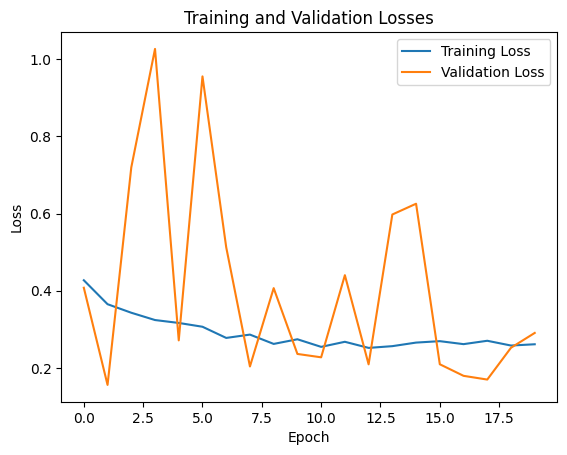

In [25]:
# Plot the loss curves
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [26]:
def inference(test_data):
    idx = torch.randint(1, len(test_data), (1,))
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)
    
    if torch.sigmoid(model(sample)) < 0.5:
        print("Prediction : Malignant")
    else:
        print("Prediction : Benign")
    
    plt.imshow(test_data[idx][0].permute(1, 2, 0))

Prediction : Benign


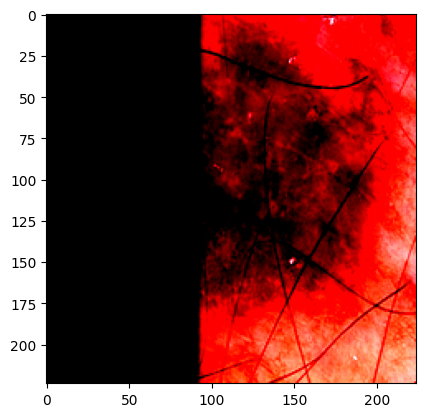

In [27]:
inference(test_data)

### Second type of inferencing

In [28]:
def inference(test_data, test_labels):
    idx = torch.randint(1, len(test_data), (1,))
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)
#     true_label = test_labels[idx].unsqueeze(1).float()
    true_label = torch.tensor([test_labels[idx]], dtype=torch.float32)  # Get the corresponding true label
    true_label = true_label.unsqueeze(1).to(device)
    
    with torch.no_grad():
        output = torch.sigmoid(model(sample))
        print(output)
        predicted_label = 1 if output >= 0.5 else 0
        print(true_label)
        loss = loss_fn(output, true_label)
        print(loss)
        accuracy = 1 if predicted_label == true_label else 0
    
    if predicted_label == 0:
        print("Prediction: Benign")
    else:
        print("Prediction: Malignant")
    
    print("Ground Truth: Benign" if true_label == 0 else "Ground Truth: Malignant")
    print("Test Loss:", loss.item())
    print("Test Accuracy:", accuracy)
    
    plt.imshow(test_data[idx][0].permute(1, 2, 0))

tensor([[0.2960]], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor(0.8520, device='cuda:0')
Prediction: Benign
Ground Truth: Benign
Test Loss: 0.8520441055297852
Test Accuracy: 1


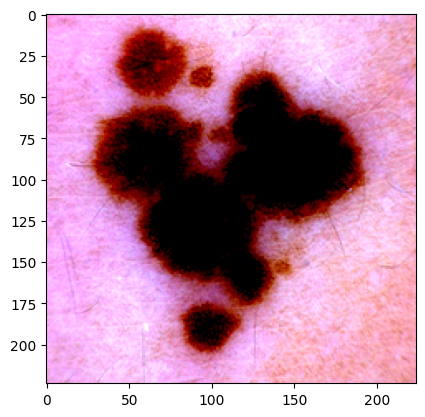

In [29]:
# Example usage:
inference(test_data, test_data.targets)

In [30]:
from PIL import Image

In [31]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

In [32]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [33]:
#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer

classifier_head = nn.Sequential(
nn.Linear(nr_filters, 512),
nn.ReLU(inplace=True),
nn.Dropout(p=0.5),
nn.Linear(512, 1))
model.fc = classifier_head

In [34]:
model_path = "/kaggle/working/skin_cancer_2.pth"

In [35]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
def inference(image_path):
    # Load and apply transformations to the single image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    transformed_image = transform(image).unsqueeze(0)
    
    # Perform inference
    with torch.no_grad():
        output = torch.sigmoid(model(transformed_image))
    
    print(output)
    # Interpret the output
    if output < 0.5:
        print("Prediction: Benign")
    else:
        print("Prediction: Malignant")
    
    # Plot the image
    plt.imshow(image)

tensor([[0.3866]])
Prediction: Benign


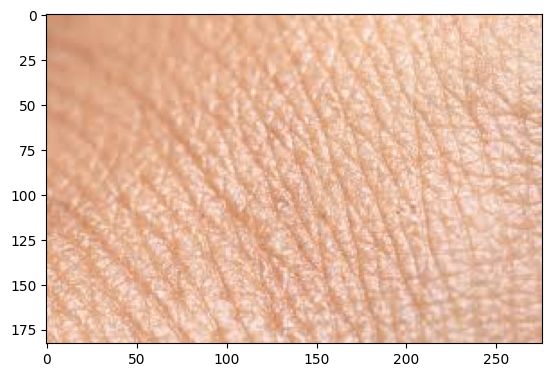

In [37]:
test_image = inference("/kaggle/input/test-image/images.jpg")

# Approach 2: Let us try another approach with the model using RegNet Architecture for resource contraint systems

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, f1_score, recall_score

In [28]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


In [29]:
imgSize = 224

transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.7592, 0.7592, 0.7592], std=[0.0900, 0.0900, 0.0900])
    transforms.Normalize(mean=[0.7592, 0.5374, 0.5389], std=[0.0900, 0.1136, 0.1265])
])

In [30]:
path = '/kaggle/input/hackathon-new/Hacklytics/data/train'
valPath = '/kaggle/input/hackathon-new/Hacklytics/data/test'

In [31]:
trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = transformer)

In [32]:
# Data loaders
batchSize = 32

In [33]:
trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [34]:
model = models.regnet_y_8gf(weights = 'DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 1)

model = nn.DataParallel(model).to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_8gf-dc2b1b54.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-dc2b1b54.pth
100%|██████████| 151M/151M [00:01<00:00, 149MB/s]  


In [36]:
# Defining the loss, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

In [37]:
# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
trainAcc = []
valLosses = []
valAccs = []

In [38]:
# Training loop
epochs = 20
patience = 8
minDelta = 0.03
currentPatience = 0
bestLoss = float('inf')

for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0
    total_train = correct_train = 0
    
    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        # Use parameter.grad = None instead of optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            predicted_train = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()
        
    accuracyTrain = correct_train/total_train * 100
    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f} Training Accuracy : {accuracyTrain:2f}')
    trainLosses.append(trainLoss)
    trainAcc.append(accuracyTrain)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step(avgLoss)

Epoch 1/20 - Training Loss : 0.43 Training Accuracy : 81.396212
Validation Loss : 0.31 Validation Accuracy : 85.45

Epoch 2/20 - Training Loss : 0.33 Training Accuracy : 85.258076
Validation Loss : 0.37 Validation Accuracy : 84.39

Epoch 3/20 - Training Loss : 0.34 Training Accuracy : 85.146677
Validation Loss : 0.34 Validation Accuracy : 85.91

Epoch 4/20 - Training Loss : 0.28 Training Accuracy : 87.151875
Validation Loss : 0.29 Validation Accuracy : 85.61

Epoch 5/20 - Training Loss : 0.27 Training Accuracy : 88.228741
Validation Loss : 0.26 Validation Accuracy : 88.94

Epoch 6/20 - Training Loss : 0.27 Training Accuracy : 88.562941
Validation Loss : 0.32 Validation Accuracy : 86.82

Epoch 7/20 - Training Loss : 0.27 Training Accuracy : 87.894541
Validation Loss : 0.38 Validation Accuracy : 83.48

Epoch 8/20 - Training Loss : 0.24 Training Accuracy : 89.825473
Validation Loss : 0.33 Validation Accuracy : 87.88

Epoch 9/20 - Training Loss : 0.22 Training Accuracy : 90.345340
Validati

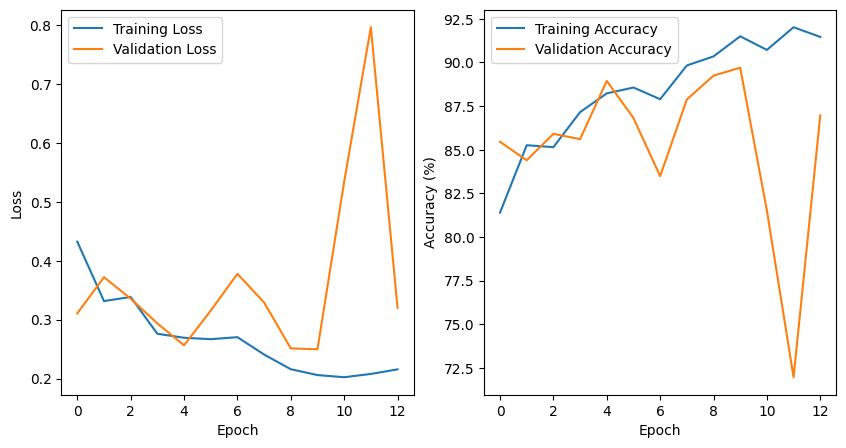

In [39]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label = 'Training Accuracy')
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [40]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'skin_cancer_detection_regnet_8gf_92_58.pth')

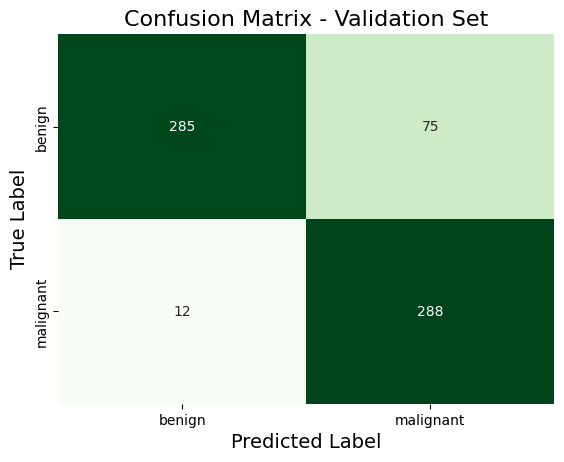

 Precision : 0.79  Recall : 0.96 F1 score : 0.87



In [41]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

precision = precision_score(allLabels, allPreds, average='binary')
recall = recall_score(allLabels, allPreds, average='binary')
f1 = f1_score(allLabels, allPreds, average='binary')

# Print the results
print(f' Precision : {precision:.2f}  Recall : {recall:.2f} F1 score : {f1:.2f}\n')

In [42]:
from PIL import Image

model_path = "/kaggle/working/skin_cancer_detection_regnet_8gf_92_58.pth"

model = models.regnet_y_8gf(weights = 'DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 1)

model = nn.DataParallel(model).to(device)

model.load_state_dict(torch.load(model_path))
imgSize = 224


In [53]:
# Load the image from a file
image = Image.open('/kaggle/input/hackathon-new/Hacklytics/test_img/ISIC_0032629.jpg')

# Apply the same transformations as the training data
transformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7592, 0.5374, 0.5389], std=[0.0900, 0.1136, 0.1265])
])

# Convert the image to a tensor and add a batch dimension
tensor = transformer(image)
tensor = torch.unsqueeze(tensor, 0)

# Move the tensor to the same device as the model
tensor = tensor.to(device)

# Get the model output
output = model(tensor)

# Apply a threshold or a sigmoid function to get the predicted class
# For example, if the output is greater than 0, predict malignant, otherwise benign
threshold = 0.5
predicted = 'malignant' if output > threshold else 'benign'
print(f'The predicted class is {predicted}')

The predicted class is benign
